In [ ]:
import os
from google.colab import drive


drive.mount('/content/drive')


dataset_path = "/content/drive/My Drive/CF_Dataset"


modalities = ["X-Ray", "CT", "MRI"]
classes = ["CF", "Non-CF"]
for modality in modalities:
    for category in classes:
        os.makedirs(os.path.join(dataset_path, modality, category), exist_ok=True)

print("Directories created successfully at:", dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directories created successfully at: /content/drive/My Drive/CF_Dataset


In [ ]:
!pip install pydicom

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


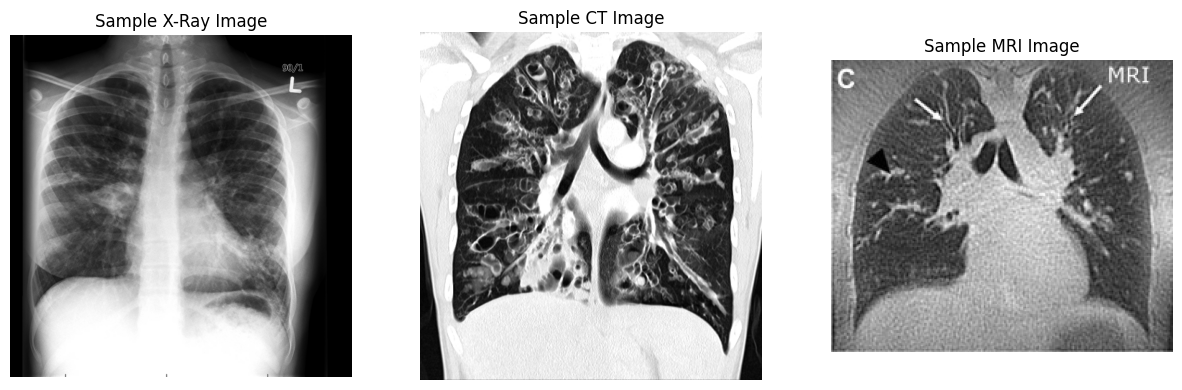

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive


drive.mount('/content/drive')


dataset_path = "/content/drive/My Drive/CF_Dataset"


def load_image(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def display_sample_images():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, modality in enumerate(["X-Ray", "CT", "MRI"]):
        folder_path = os.path.join(dataset_path, modality, "CF")
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg'))]

        if image_files:
            image_path = os.path.join(folder_path, image_files[0])
            image = load_image(image_path)
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f"Sample {modality} Image")
            axes[i].axis('off')

    plt.show()


display_sample_images()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


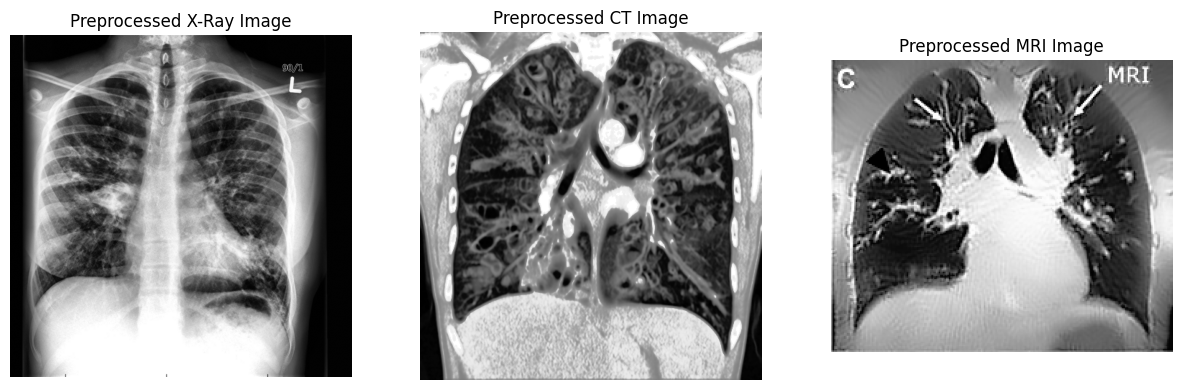

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive


drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/CF_Dataset"

def remove_noise(image, modality):
    if modality == "X-Ray":
        return cv2.medianBlur(image, 3)
    elif modality == "CT":
        return cv2.GaussianBlur(image, (5, 5), 0)
    elif modality == "MRI":
        return cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

# Contrast Enhancement Functions
def enhance_contrast(image, modality):
    if modality == "X-Ray":
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(image)
    elif modality == "CT":
        return cv2.equalizeHist(image)
    elif modality == "MRI":
        return cv2.equalizeHist(image)


def preprocess_image(image_path, modality):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = remove_noise(image, modality)
    image = enhance_contrast(image, modality)
    return image


def display_preprocessed_images():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, modality in enumerate(["X-Ray", "CT", "MRI"]):
        folder_path = os.path.join(dataset_path, modality, "CF")
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg'))]

        for img_file in image_files:
            image_path = os.path.join(folder_path, img_file)
            preprocessed_image = preprocess_image(image_path, modality)
            axes[i].imshow(preprocessed_image, cmap='gray')
            axes[i].set_title(f"Preprocessed {modality} Image")
            axes[i].axis('off')
            break

    plt.show()

display_preprocessed_images()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


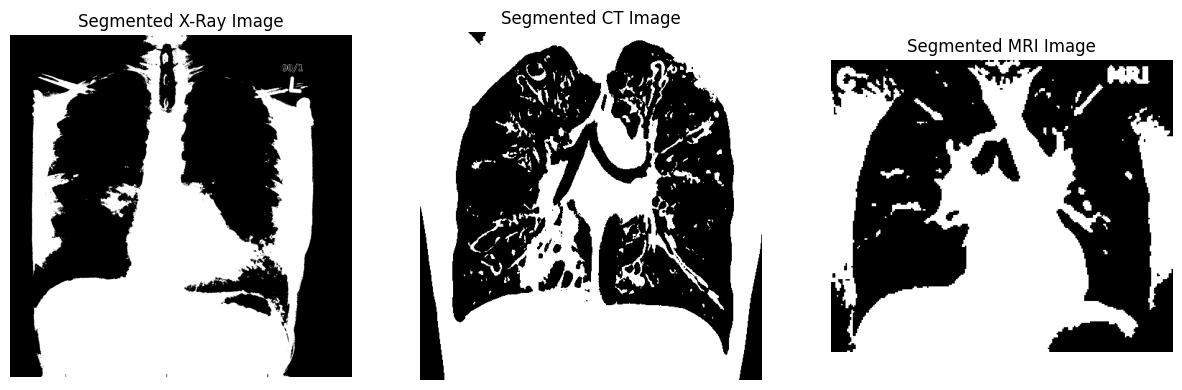

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
from google.colab import drive

drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/CF_Dataset"


def segment_xray(image):
    _, segmented = cv2.threshold(image, threshold_otsu(image), 255, cv2.THRESH_BINARY)
    return segmented


def segment_ct(image):
    reshaped = image.reshape((-1, 1))
    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
    kmeans.fit(reshaped)
    clustered = kmeans.labels_.reshape(image.shape)
    segmented = (clustered * 255).astype(np.uint8)
    return segmented

def segment_mri(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = cv2.GaussianBlur(image, (5, 5), 0)
    otsu_thresh = threshold_otsu(image)
    _, segmented = cv2.threshold(image, otsu_thresh, 255, cv2.THRESH_BINARY)

    return segmented


def segment_lung(image, modality):
    if modality == "X-Ray":
        return segment_xray(image)
    elif modality == "CT":
        return segment_ct(image)
    elif modality == "MRI":
        return segment_mri(image)


def display_segmented_images():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, modality in enumerate(["X-Ray", "CT", "MRI"]):
        folder_path = os.path.join(dataset_path, modality, "CF")
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg'))]

        for img_file in image_files:
            image_path = os.path.join(folder_path, img_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image
            segmented_image = segment_lung(image, modality)
            axes[i].imshow(segmented_image, cmap='gray')
            axes[i].set_title(f"Segmented {modality} Image")
            axes[i].axis('off')
            break

    plt.show()
display_segmented_images()


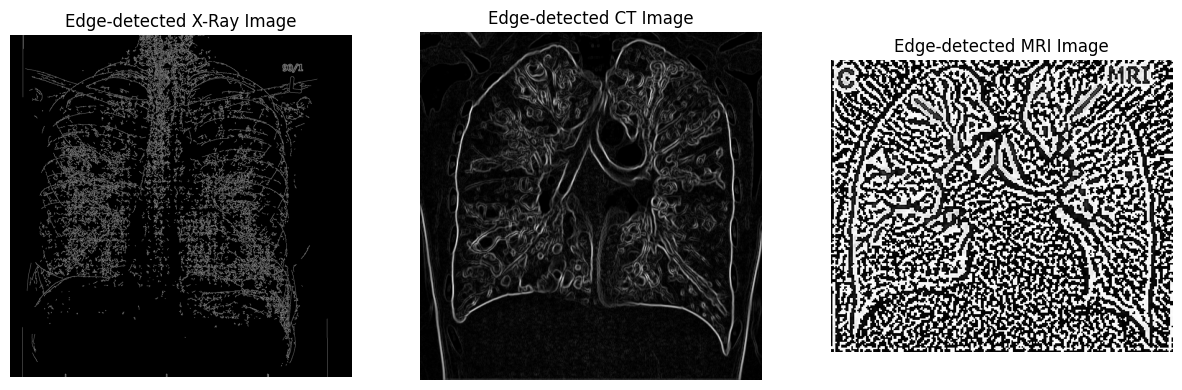

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.filters import sobel, laplace

def edge_xray(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(image)
    otsu_thresh, _ = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(enhanced, otsu_thresh * 0.5, otsu_thresh)
    return edges


def edge_ct(image):
    sobel_edges = sobel(image)
    return (sobel_edges * 255).astype(np.uint8)


def edge_mri(image):
    blurred = cv2.GaussianBlur(image, (5,5), 0)
    log_edges = laplace(blurred)
    return (log_edges * 255).astype(np.uint8)


def detect_edges(image, modality):
    if modality == "X-Ray":
        return edge_xray(image)
    elif modality == "CT":
        return edge_ct(image)
    elif modality == "MRI":
        return edge_mri(image)

def display_edge_detected_images():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, modality in enumerate(["X-Ray", "CT", "MRI"]):
        folder_path = os.path.join(dataset_path, modality, "CF")
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg'))]

        for img_file in image_files:
            image_path = os.path.join(folder_path, img_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            edge_image = detect_edges(image, modality)
            axes[i].imshow(edge_image, cmap='gray')
            axes[i].set_title(f"Edge-detected {modality} Image")
            axes[i].axis('off')
            break

    plt.show()


display_edge_detected_images()

In [ ]:
import cv2
import numpy as np
import os
import skimage.measure
from skimage.feature import graycomatrix, graycoprops


def extract_texture_features(image):
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return [contrast, correlation, energy, homogeneity]


def extract_shape_features(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return [0, 0, 0, 0]
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    _, _, w, h = cv2.boundingRect(largest_contour)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0
    return [area, perimeter, w/h, circularity]

def extract_intensity_features(image):
    mean_intensity = np.mean(image)
    std_dev = np.std(image)
    skewness = skimage.measure.shannon_entropy(image)
    return [mean_intensity, std_dev, skewness]


def extract_features(image):
    texture_features = extract_texture_features(image)
    shape_features = extract_shape_features(image)
    intensity_features = extract_intensity_features(image)
    return texture_features + shape_features + intensity_features

test_image = np.random.randint(0, 255, (256, 256), dtype=np.uint8)
features = extract_features(test_image)
print("Extracted Features:", features)

Extracted Features: [np.float64(10958.685937500002), np.float64(-0.007207119508484185), np.float64(0.004801858288685532), np.float64(0.0113486035750178), 65019.0, 1024.9705624580383, 1.0, 0.7777273373300425, np.float64(126.85530090332031), np.float64(73.75021856951545), np.float64(7.991328625220241)]


In [ ]:
def display_features(features):
    feature_names = [
        "GLCM Contrast", "GLCM Correlation", "GLCM Energy", "GLCM Homogeneity",
        "Area", "Perimeter", "Aspect Ratio (W/H)", "Circularity",
        "Mean Intensity", "Standard Deviation", "Entropy"
    ]

    print("\n-Extracted Features:")
    for name, value in zip(feature_names, features):
        print(f"{name:30}: {value:.4f}")


display_features(features)


-Extracted Features:
GLCM Contrast                 : 10958.6859
GLCM Correlation              : -0.0072
GLCM Energy                   : 0.0048
GLCM Homogeneity              : 0.0113
Area                          : 65019.0000
Perimeter                     : 1024.9706
Aspect Ratio (W/H)            : 1.0000
Circularity                   : 0.7777
Mean Intensity                : 126.8553
Standard Deviation            : 73.7502
Entropy                       : 7.9913


In [ ]:

from google.colab import drive
import cv2
import numpy as np
import os
import skimage.measure
from skimage.feature import graycomatrix, graycoprops


drive.mount('/content/drive')


dataset_path = "/content/drive/MyDrive/CF_Dataset"


def extract_texture_features(image):
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return [contrast, correlation, energy, homogeneity]

def extract_shape_features(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return [0, 0, 0, 0]
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    _, _, w, h = cv2.boundingRect(largest_contour)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0
    return [area, perimeter, w/h, circularity]

def extract_intensity_features(image):
    mean_intensity = np.mean(image)
    std_dev = np.std(image)
    entropy = skimage.measure.shannon_entropy(image)
    return [mean_intensity, std_dev, entropy]

def extract_features(image):
    texture_features = extract_texture_features(image)
    shape_features = extract_shape_features(image)
    intensity_features = extract_intensity_features(image)
    return texture_features + shape_features + intensity_features

def create_feature_dataset(modality):
    data = []
    labels = []

    modality_path = os.path.join(dataset_path, modality)
    categories = ["CF", "Non-CF"]

    for category in categories:
        category_path = os.path.join(modality_path, category)

        if not os.path.exists(category_path):
            print(f"Skipping missing folder: {category_path}")
            continue

        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)

            try:
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Skipping unreadable file: {file_path}")
                    continue


                image = cv2.resize(image, (256, 256))


                features = extract_features(image)

                data.append(features)
                labels.append(1 if category == "CF" else 0)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    return np.array(data), np.array(labels)


modalities = ["X-Ray", "MRI", "CT"]
feature_datasets = {}

for modality in modalities:
    print(f"\nProcessing {modality} images...")
    X, y = create_feature_dataset(modality)
    print(f"✅ {modality} Dataset Shape: {X.shape}, Labels Shape: {y.shape}")
    feature_datasets[modality] = (X, y)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Processing X-Ray images...
✅ X-Ray Dataset Shape: (52, 11), Labels Shape: (52,)

Processing MRI images...
✅ MRI Dataset Shape: (51, 11), Labels Shape: (51,)

Processing CT images...
✅ CT Dataset Shape: (83, 11), Labels Shape: (83,)


In [ ]:
from sklearn.model_selection import train_test_split

# Extracting X-ray data
X_xray, y_xray = feature_datasets["X-Ray"]

# Ensure both classes are represented in training
X_train, X_test, y_train, y_test = train_test_split(
    X_xray, y_xray, test_size=0.2, stratify=y_xray, random_state=42
)


print("Training Class Distribution:", np.bincount(y_train))
print("Testing Class Distribution:", np.bincount(y_test))


Training Class Distribution: [24 17]
Testing Class Distribution: [6 5]


-LOOCV Accuracy for X-ray CF Detection: 0.9423
-Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.91      0.95      0.93        22

    accuracy                           0.94        52
   macro avg       0.94      0.94      0.94        52
weighted avg       0.94      0.94      0.94        52



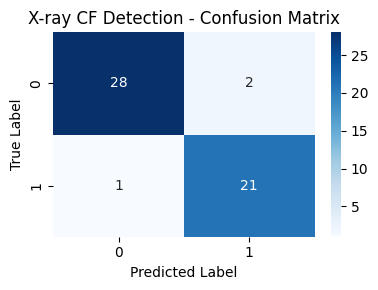

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

y_true, y_pred = [], []


for train_idx, test_idx in loo.split(X_xray):
    X_train, X_test = X_xray[train_idx], X_xray[test_idx]
    y_train, y_test = y_xray[train_idx], y_xray[test_idx]

    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)

    y_true.append(y_test[0])
    y_pred.append(pred[0])


accuracy = accuracy_score(y_true, y_pred)
print(f"-LOOCV Accuracy for X-ray CF Detection: {accuracy:.4f}")
print("-Classification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
labels = sorted(list(set(y_true)))  # Unique class labels

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('X-ray CF Detection - Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:

X_mri, y_mri = feature_datasets["MRI"]

print(f"-MRI Features Shape: {X_mri.shape}, Labels Shape: {y_mri.shape}")


-MRI Features Shape: (51, 11), Labels Shape: (51,)


In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_mri_scaled = scaler.fit_transform(X_mri)

print("- MRI Features Normalized")


- MRI Features Normalized


In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=0.95)
X_mri_pca = pca.fit_transform(X_mri_scaled)

print(f"- MRI Features after PCA: {X_mri_pca.shape}")


- MRI Features after PCA: (51, 5)



-LOOCV Accuracy for MRI CF Detection: 0.9608

-Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.95      0.97        38

    accuracy                           0.96        51
   macro avg       0.93      0.97      0.95        51
weighted avg       0.97      0.96      0.96        51



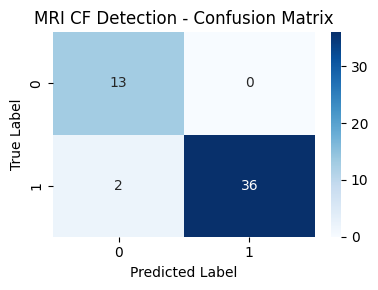

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

loo = LeaveOneOut()
svm = SVC(kernel='linear')

accuracies = []
y_true, y_pred = [], []


for train_index, test_index in loo.split(X_mri_pca):
    X_train, X_test = X_mri_pca[train_index], X_mri_pca[test_index]
    y_train, y_test = y_mri[train_index], y_mri[test_index]


    svm.fit(X_train, y_train)


    pred = svm.predict(X_test)
    accuracies.append(accuracy_score(y_test, pred))


    y_true.append(y_test[0])
    y_pred.append(pred[0])

final_accuracy = np.mean(accuracies)
print(f"\n-LOOCV Accuracy for MRI CF Detection: {final_accuracy:.4f}")


print("\n-Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
labels = sorted(list(set(y_true)))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MRI CF Detection - Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:

X_ct, y_ct = feature_datasets["CT"]


print(f"-CT Dataset Shape: {X_ct.shape}, Labels Shape: {y_ct.shape}")


-CT Dataset Shape: (83, 11), Labels Shape: (83,)


-LOOCV Accuracy for CT CF Detection: 0.9036

-Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        47
           1       0.97      0.81      0.88        36

    accuracy                           0.90        83
   macro avg       0.92      0.89      0.90        83
weighted avg       0.91      0.90      0.90        83



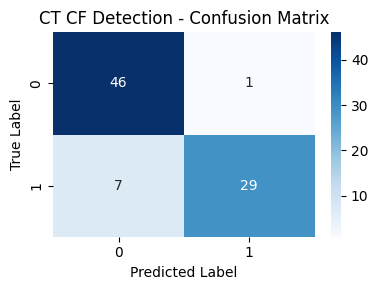

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

loo = LeaveOneOut()
y_true, y_pred = [], []


for train_index, test_index in loo.split(X_ct):
    X_train, X_test = X_ct[train_index], X_ct[test_index]
    y_train, y_test = y_ct[train_index], y_ct[test_index]


    model = SVC(kernel='linear')
    model.fit(X_train, y_train)


    y_pred.append(model.predict(X_test)[0])
    y_true.append(y_test[0])


accuracy_ct = accuracy_score(y_true, y_pred)
print(f"-LOOCV Accuracy for CT CF Detection: {accuracy_ct:.4f}")


print("\n-Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
labels = sorted(list(set(y_true)))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CT CF Detection - Confusion Matrix')
plt.tight_layout()
plt.show()

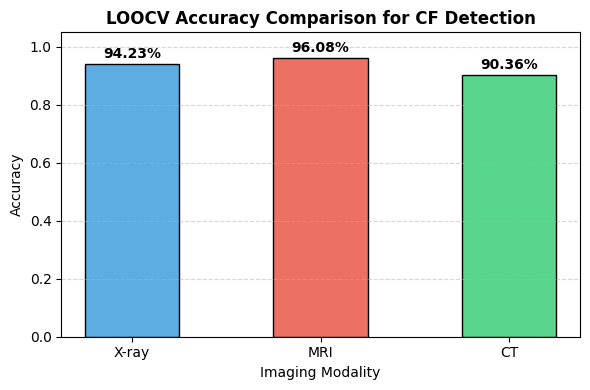

In [ ]:
import matplotlib.pyplot as plt

modalities = ['X-ray', 'MRI', 'CT']
accuracies = [accuracy, final_accuracy, accuracy_ct]
colors = ['#5DADE2', '#EC7063', '#58D68D']

x = [0, 0.5, 1]

plt.figure(figsize=(6, 4))
bars = plt.bar(x, accuracies, width=0.25, color=colors, edgecolor='black')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2%}',
             ha='center', fontsize=10, fontweight='bold')

plt.xticks(x, modalities, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.05)
plt.xlabel('Imaging Modality', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('LOOCV Accuracy Comparison for CF Detection', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()